# Analysis More Time Temp & Wind with Future test
This notebook contains exploratory data analysis and plots to asses GAN performance.

## Packages

In [1]:
# data
import netCDF4 as nc
import numpy as np

import pandas as pd

# models 
import tensorflow as tf
print(tf.__version__)
#tf.disable_eager_execution()
#tf.enable_eager_execution()
tf.compat.v1.enable_eager_execution()

# must be True
print(tf.executing_eagerly())

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

import helper_functions as hf
from skimage.metrics import structural_similarity as ssim

import importlib as imp

2.8.0
True


In [2]:
imp.reload(hf)

<module 'helper_functions' from 'E:\\Universiteit\\Jaar_6\\Master_Thesis_Part_2\\Sebastian_modified_software\\helper_functions.py'>

## Reading data

Data is from two sources EC Earth and WRF. WRF is 4km. EC Earth is originally at resolution 25km but use interpolated to 18km.

In [3]:
# TRAIN

# WRF 3km
T_WRF_3km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_WRF_3km.npy')
U_WRF_3km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_3km.npy')
V_WRF_3km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_3km.npy')

# WRF 9km
T_WRF_9km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_WRF_9km.npy')
U_WRF_9km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_9km.npy')
V_WRF_9km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_9km.npy')

# NCEP
T_NCEP_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_NCEP_near.npy')
U_NCEP_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_NCEP_near.npy')
V_NCEP_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_NCEP_near.npy')

# NCEP
T_NCEP_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_NCEP_down.npy')
U_NCEP_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_NCEP_down.npy')
V_NCEP_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_NCEP_down.npy')

In [4]:
# TEST Future

# WRF 4km
T_WRF_4km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_WRF_4km.npy')
U_WRF_4km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_WRF_4km.npy')
V_WRF_4km = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_WRF_4km.npy')

#EC Earth
ds_ECEarth_2041 = nc.Dataset('F:/Master_Thesis/Data/EC Earth/2041_UVT/UVT_EcEarth_2041_25km_3h.nc')
T_ECEarth_2041_25km = np.array(ds_ECEarth_2041['T2M'])
U_ECEarth_2041_25km = np.array(ds_ECEarth_2041['U10M'])
V_ECEarth_2041_25km = np.array(ds_ECEarth_2041['V10M'])
T_ECEarth_2041_25km = T_ECEarth_2041_25km[:,:,1:26]
U_ECEarth_2041_25km = U_ECEarth_2041_25km[:,:,1:26]
V_ECEarth_2041_25km = V_ECEarth_2041_25km[:,:,1:26]

T_ECEarth_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_ECEarth_down.npy')
U_ECEarth_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_ECEarth_down.npy')
V_ECEarth_down = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_ECEarth_down.npy')

T_ECEarth_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/T_ECEarth_near.npy')
U_ECEarth_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/U_ECEarth_near.npy')
V_ECEarth_near = np.load('F:/Master_Thesis/Data/Analysis_More_Time/V_ECEarth_near.npy')

#coordinates
lon_ECEarth_25km_2041 = np.array(ds_ECEarth_2041['lon'])
lat_ECEarth_25km_2041 = np.array(ds_ECEarth_2041['lat'])


if(len(lat_ECEarth_25km_2041.shape)==1):
    lon_ECEarth_25km_2041, lat_ECEarth_25km_2041 = np.meshgrid(lon_ECEarth_25km_2041, lat_ECEarth_25km_2041)
    
lon_ECEarth_25km_2041=lon_ECEarth_25km_2041[:,1:26]    
lat_ECEarth_25km_2041=lat_ECEarth_25km_2041[:,1:26] 

Bicubic interpolation, as a control downscaling technique.

In [5]:
T_bicubic = hf.regrid(hf.downscale_image(T_NCEP_down, K=1/3),2)
U_bicubic = hf.regrid(hf.downscale_image(U_NCEP_down, K=1/3),2)
V_bicubic = hf.regrid(hf.downscale_image(V_NCEP_down, K=1/3),2)

In [6]:
T_bicubic_test = hf.regrid(hf.downscale_image(T_ECEarth_down, K=1/3),2)
U_bicubic_test = hf.regrid(hf.downscale_image(U_ECEarth_down, K=1/3),2)
V_bicubic_test = hf.regrid(hf.downscale_image(V_ECEarth_down, K=1/3),2)

## Exploratory Data Analysis

#### Plot style

In [7]:
import matplotlib as mpl
import matplotlib.colors as mcol

# fontsize
fs = 20

# colormaps
cmap = plt.cm.Spectral  # define the colormap

# define the bins and normalize
# Temperature
T_bounds = range(250,320,1)
T_norm = mcol.BoundaryNorm(T_bounds,cmap.N)

# Wind
W_bounds = range(-40,40,2)
W_norm = mcol.BoundaryNorm(W_bounds,cmap.N)

#### Mu_sig distributions

In [8]:
print(np.mean(T_NCEP_near),np.std(T_NCEP_near))
print(np.mean(T_WRF_9km),np.std(T_WRF_9km))
print('\n')
print(np.mean(T_ECEarth_down),np.std(T_ECEarth_down))

284.07272 8.4506645
283.68134 8.747754


283.60394 9.736452


In [9]:
print(np.mean(U_NCEP_near),np.std(U_NCEP_near))
print(np.mean(U_WRF_9km),np.std(U_WRF_9km))
print('\n')
print(np.mean(U_ECEarth_down),np.std(U_ECEarth_down))

-0.17836592 1.3971868
-0.41113052 2.5920742


-0.05610011 1.3851143


In [10]:
print(np.mean(V_NCEP_near),np.std(V_NCEP_near))
print(np.mean(V_WRF_9km),np.std(V_WRF_9km))
print(np.mean(V_WRF_3km),np.std(V_WRF_3km))
print('\n')
print(np.mean(V_ECEarth_down),np.std(V_ECEarth_down))

-0.3488957 1.6794369
-0.7684929 2.6798747
-0.360848 2.5251336


-0.3573082 1.4542388


### RMSE and SSIM
RMSE is the root-mean squared error and will tell about the absolute error between two datasets. SSIM is the structural similarity index measure and will tell about how much the datasets look similar based on their structure. Of course RMSE and SSIM are correlated to a certain degree, but it is possible to keep RMSE constant and vary SSIM.

For deeper understanding we look into these performance measures over time and space.

In [11]:
#selecting right range

T_WRF_9km = T_WRF_9km[:,0:30,0:30]
U_WRF_9km = U_WRF_9km[:,0:30,0:30]
V_WRF_9km = V_WRF_9km[:,0:30,0:30]

T_WRF_3km = T_WRF_3km[:,0:30,0:30]
U_WRF_3km = U_WRF_3km[:,0:30,0:30]
V_WRF_3km = V_WRF_3km[:,0:30,0:30]

## Interpolating WRF 4km to a WRF 3km grid
#reading data coordinates in
ds_WRF2041 = nc.Dataset('F:/Master_Thesis/Data/WRF data/wrf_2041_4km_3h.nc')
lon_WRF_4km_2041 = np.array(ds_WRF2041['XLONG'])
lat_WRF_4km_2041 = np.array(ds_WRF2041['XLAT'])

c5 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LAT_Garda_d02_part1.nc')
c6 = nc.Dataset('F:/Master_Thesis/Data/WRF data/More_time_runs/LON_Garda_d02_part1.nc')
lat_WRF_3km_part1 = np.array(c5['XLAT'][0])[:,0:96]
lon_WRF_3km_part1 = np.array(c6['XLONG'][0])[:,0:96]

# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_4km_2041.flatten(), lat_WRF_4km_2041.flatten())
tree = hf.cKDTree(np.column_stack((xs, ys, zs)))
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

# nearest neighbour
T_WRF_4km_near = hf.transform_extent(T_WRF_4km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
U_WRF_4km_near = hf.transform_extent(U_WRF_4km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]
V_WRF_4km_near = hf.transform_extent(V_WRF_4km, inds, lat_WRF_3km_part1.shape)[0:T_WRF_9km.shape[0]]

T_WRF_4km_near = T_WRF_4km_near[:,0:30,0:30]
U_WRF_4km_near = U_WRF_4km_near[:,0:30,0:30]
V_WRF_4km_near = V_WRF_4km_near[:,0:30,0:30]

In [12]:
#Interpolating SR HR data to a WRF 4km grid

#SR data
temp_mr_hr_SR_train = np.load('F:/Master_Thesis/Data/SR_data/More_Time/temperature/MR_HR/dataSR.npy')[:,:,:,0]
temp_mr_hr_SR_test = np.load('F:/Master_Thesis/Data/SR_data/More_Time/temperature/MR_HR/Future/dataSR.npy')[:,:,:,0]

Wind_SR_train = np.load('F:/Master_Thesis/Data/SR_data/More_Time/wind/MR_HR/dataSR.npy')
Wind_SR_test = np.load('F:/Master_Thesis/Data/SR_data/More_Time/wind/MR_HR/Future/dataSR.npy')

U_mr_hr_train = Wind_SR_train[:,:,:,0]
U_mr_hr_test = Wind_SR_test[:,:,:,0]

V_mr_hr_train = Wind_SR_train[:,:,:,1]
V_mr_hr_test = Wind_SR_test[:,:,:,1]

# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_4km_2041.flatten(), lat_WRF_4km_2041.flatten())
xs, ys, zs = hf.lon_lat_to_cartesian(lon_WRF_3km_part1.flatten(), lat_WRF_3km_part1.flatten())
tree = hf.cKDTree(np.column_stack((xs, ys, zs)))
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

# nearest neighbour
T_mr_hr_test_near = hf.transform_extent(temp_mr_hr_SR_test, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]
U_mr_hr_test_near = hf.transform_extent(U_mr_hr_test, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]
V_mr_hr_test_near = hf.transform_extent(V_mr_hr_test, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]

In [13]:
#Interpolating EC Earth naar WRF4km

# target cartesian coordinates
xt, yt, zt = hf.lon_lat_to_cartesian(lon_WRF_4km_2041.flatten(), lat_WRF_4km_2041.flatten())
xs, ys, zs = hf.lon_lat_to_cartesian(lon_ECEarth_25km_2041.flatten(), lat_ECEarth_25km_2041.flatten())
tree = hf.cKDTree(np.column_stack((xs, ys, zs)))
d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 1)

# nearest neighbour
T_ECEarth_4km_near = hf.transform_extent(T_ECEarth_2041_25km, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]
U_ECEarth_4km_near = hf.transform_extent(T_ECEarth_2041_25km, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]
V_ECEarth_4km_near = hf.transform_extent(T_ECEarth_2041_25km, inds, lat_WRF_4km_2041.shape)[0:T_WRF_4km.shape[0]]

In [15]:
T_rms_NCEP_downv9km, T_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(T_NCEP_down,6), T_WRF_9km, 'array')
U_rms_NCEP_downv9km, U_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(U_NCEP_down,6), U_WRF_9km, 'array')
V_rms_NCEP_downv9km, V_ssim_NCEP_downv9km = hf.performance_dataset(hf.regrid(V_NCEP_down,6), V_WRF_9km, 'array')

T_rms_NCEP_downv3km, T_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(T_NCEP_down,6), T_WRF_3km, 'array')
U_rms_NCEP_downv3km, U_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(U_NCEP_down,6), U_WRF_3km, 'array')
V_rms_NCEP_downv3km, V_ssim_NCEP_downv3km = hf.performance_dataset(hf.regrid(V_NCEP_down,6), V_WRF_3km, 'array')

In [16]:
T_rms_bicubicv9km, T_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(T_bicubic), T_WRF_9km, 'array')
U_rms_bicubicv9km, U_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(U_bicubic), U_WRF_9km, 'array')
V_rms_bicubicv9km, V_ssim_bicubicv9km = hf.performance_dataset(np.squeeze(V_bicubic), V_WRF_9km, 'array')

In [17]:
# RMSE and SSIM per pixel
T_rms_map, T_ssim_map = hf.performance_map(T_WRF_3km,T_NCEP_near)
U_rms_map, U_ssim_map = hf.performance_map(U_WRF_3km,U_NCEP_near)
V_rms_map, V_ssim_map = hf.performance_map(V_WRF_3km,V_NCEP_near)

In [18]:
#EC Earth downv4km and 3km
T_rms_ECEarth_downv4km, T_ssim_ECEarth_downv4km = hf.performance_dataset(T_ECEarth_4km_near, T_WRF_4km, 'array')
U_rms_ECEarth_downv4km, U_ssim_ECEarth_downv4km = hf.performance_dataset(U_ECEarth_4km_near, U_WRF_4km, 'array')
V_rms_ECEarth_downv4km, V_ssim_ECEarth_downv4km = hf.performance_dataset(V_ECEarth_4km_near, V_WRF_4km, 'array')

T_rms_ECEarth_downv3km, T_ssim_ECEarth_downv3km = hf.performance_dataset(hf.regrid(T_ECEarth_down,6), T_WRF_3km, 'array')
U_rms_ECEarth_downv3km, U_ssim_ECEarth_downv3km = hf.performance_dataset(hf.regrid(U_ECEarth_down,6), U_WRF_3km, 'array')
V_rms_ECEarth_downv3km, V_ssim_ECEarth_downv3km = hf.performance_dataset(hf.regrid(V_ECEarth_down,6), V_WRF_3km, 'array')

(2920, 31, 31)
(2920, 17, 11)


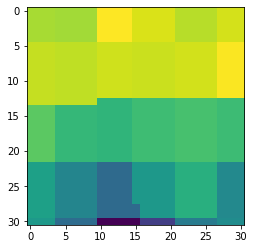

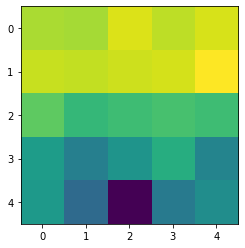

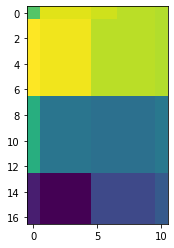

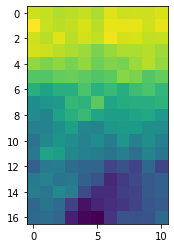

In [19]:
#print(T_WRF_4km.shape)
#print(T_WRF_4km_near.shape)
plt.imshow(T_ECEarth_near[1,:,:])
plt.figure()
plt.imshow(T_ECEarth_down[1,:,:])
#print(T_ECEarth_down.shape)
print(T_ECEarth_near.shape)
plt.figure()
plt.imshow(T_ECEarth_4km_near[0,:,:])
print(T_ECEarth_4km_near.shape)

plt.figure()
plt.imshow(T_mr_hr_test_near[1,:,:])

#plt.figure()
#plt.imshow(T_WRF_4km[1,:,:])

In [20]:
np.round(np.mean(T_ssim_NCEP_downv9km),3), np.round(np.mean(U_ssim_NCEP_downv9km),2),np.round(np.mean(V_ssim_NCEP_downv9km),2)

(0.202, 0.02, 0.04)

### Superresolution problem visualised

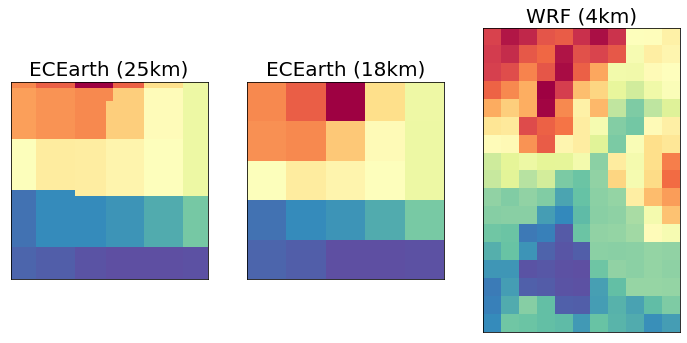

In [24]:
#EC Earth picture with WRF 4km

t = 290

fig, axs1 = plt.subplots(1, 3,figsize=(12, 6), sharey = False)

for ax, d, title in zip(axs1.flat,
                        [T_ECEarth_near, T_ECEarth_down,T_WRF_4km],
                        ['ECEarth (25km)','ECEarth (18km)','WRF (4km)']):
    im = ax.imshow(np.flipud(d[t,:,:]),cmap='Spectral')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=fs)
    
    #if title == 'ECEarth (25km)':
    #    ax.set_xlabel('RMSE (4km): %.2f\nSSIM (4km) %.2f' % 
    #                  (T_rms_ECEarth_downv3km[t],T_ssim_ECEarth_downv3km[t]), fontsize = fs-3)
    #if title == 'ECEarth (18km)':
    #    ax.set_xlabel('RMSE (4km): %.2f\nSSIM (4km) %.2f' % 
    #                  (T_rms_ECEarth_downv3km[t],T_ssim_ECEarth_downv3km[t]), fontsize = fs-3)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/ECEarth_WRF4km.pdf',bbox_inches='tight')

## Model performance

In [22]:
from datetime import datetime, timedelta



def index_to_datetime(index, start_year=2017):
    '''
    Takes the index and returns the datetime
    '''
    days = index/8 
    start = datetime(start_year,1,1,0,0,0)      
    delta = timedelta(days)     
    offset = start + delta      

    return(offset)    




### MR to HR models

#### MAPS and time

In [23]:
# map
T_mr_hr_rms_train_map, T_mr_hr_ssim_train_map = hf.performance_map(temp_mr_hr_SR_train,T_WRF_3km)
T_mr_hr_rms_test_map, T_mr_hr_ssim_test_map = hf.performance_map(T_mr_hr_test_near,T_WRF_4km)

U_mr_hr_rms_train_map, U_mr_hr_ssim_train_map = hf.performance_map(U_mr_hr_train,U_WRF_3km)
U_mr_hr_rms_test_map, U_mr_hr_ssim_test_map = hf.performance_map(U_mr_hr_test_near,U_WRF_4km)

V_mr_hr_rms_train_map, V_mr_hr_ssim_train_map = hf.performance_map(V_mr_hr_train,V_WRF_3km)
V_mr_hr_rms_test_map, V_mr_hr_ssim_test_map = hf.performance_map(V_mr_hr_test_near,V_WRF_4km)

# time
T_mr_hr_rms_train, T_mr_hr_ssim_train = hf.performance_time(temp_mr_hr_SR_train,T_WRF_3km)
T_mr_hr_rms_test, T_mr_hr_ssim_test = hf.performance_time(T_mr_hr_test_near,T_WRF_4km)

U_mr_hr_rms_train, U_mr_hr_ssim_train = hf.performance_time(U_mr_hr_train,U_WRF_3km)
U_mr_hr_rms_test, U_mr_hr_ssim_test = hf.performance_time(U_mr_hr_test_near,U_WRF_4km)

V_mr_hr_rms_train, V_mr_hr_ssim_train = hf.performance_time(V_mr_hr_train,V_WRF_3km)
V_mr_hr_rms_test, V_mr_hr_ssim_test = hf.performance_time(V_mr_hr_test_near,V_WRF_4km)

C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/2634947153.py:12: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax1, norm=S_norm)
C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/2634947153.py:45: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax4, norm=R_norm)


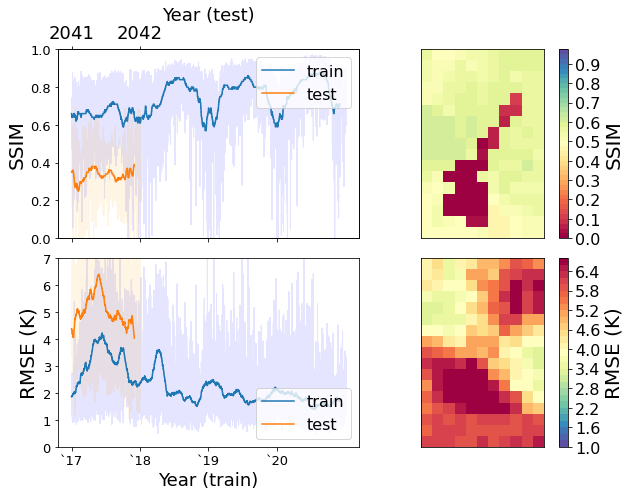

In [24]:
S_bounds = np.arange(0,1,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(1,7,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(T_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(T_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(11688),T_mr_hr_ssim_train, T_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(T_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),T_mr_hr_ssim_test, T_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-7)
ax2.set_xticks([0,2920,5840,8768])
ax2.set_xticklabels(labels=['`17','`18', '`19', '`20'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2041','2042'])




im = ax4.imshow(np.flipud(T_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (K)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(T_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(11688), T_mr_hr_rms_train, T_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(T_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), T_mr_hr_rms_test, T_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (K)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)
ax5.set_ylim([0,7])

ax5.tick_params(axis='both', labelsize=fs-7)
ax5.set_xticks([0,2920,5840,8768])
ax5.set_xticklabels(labels=['`17','`18', '`19', '`20'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()


fig.savefig('F:/Master_Thesis/Figures/Future/space_time_T2m_mrhr.pdf',bbox_inches='tight')

C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/2447251972.py:12: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax1, norm=S_norm)
C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/2447251972.py:46: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax4, norm=R_norm)


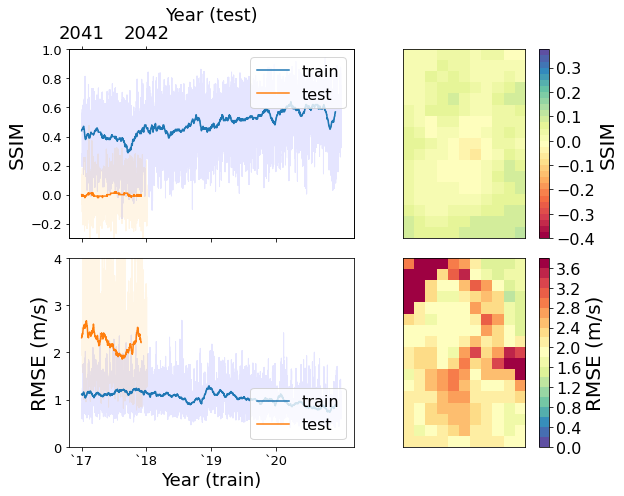

In [28]:
S_bounds = np.arange(-0.4,0.4,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(0,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(U_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(U_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(11688),U_mr_hr_ssim_train, U_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(U_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),U_mr_hr_ssim_test, U_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-7)
ax2.set_xticks([0,2920,5840,8768])
ax2.set_xticklabels(labels=['`17','`18', '`19', '`20'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2041','2042'])
ax3.set_ylim(-0.3,1)




im = ax4.imshow(np.flipud(U_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (m/s)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(U_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(11688), U_mr_hr_rms_train, U_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(U_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), U_mr_hr_rms_test, U_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (m/s)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-7)
ax5.set_xticks([0,2920,5840,8768])
ax5.set_xticklabels(labels=['`17','`18', '`19', '`20'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('F:/Master_Thesis/Figures/Future/space_time_U10m_mrhr.pdf',bbox_inches='tight')

C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/1037898122.py:12: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax1, norm=S_norm)
C:\Users\Famke\AppData\Local\Temp/ipykernel_60384/1037898122.py:45: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(im, ax = ax4, norm=R_norm)


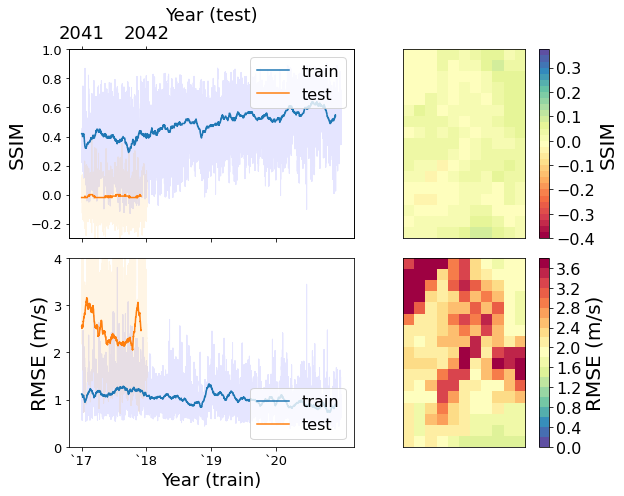

In [30]:
S_bounds = np.arange(-0.4,0.4,0.025)
S_norm = mcol.BoundaryNorm(S_bounds,cmap.N)

R_bounds = np.arange(0,4,0.2)
R_norm = mcol.BoundaryNorm(R_bounds,cmap.N)


fig, ((ax2, ax1),(ax5,ax4)) = plt.subplots(2, 2,figsize=(9,7), sharex = 'col')

im = ax1.imshow(np.flipud(V_mr_hr_ssim_test_map), cmap='Spectral', norm=S_norm)

cb = fig.colorbar(im, ax = ax1, norm=S_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='SSIM', fontsize = fs)


ax1.set_xticks([])
ax1.set_yticks([])
    

ax2.plot(hf.moving_average(V_mr_hr_ssim_train,int(24*30/3)), label= 'train')
ax2.fill_between(range(11688),V_mr_hr_ssim_train, V_mr_hr_ssim_train, color='b', alpha=.1)
ax2.set_ylim(0,1)

ax2.plot(hf.moving_average(V_mr_hr_ssim_test,int(24*30/3)), label = 'test')
ax2.fill_between(range(2920),V_mr_hr_ssim_test, V_mr_hr_ssim_test, color='orange', alpha=.1)

ax2.set_ylabel('SSIM', fontsize = fs)
ax2.legend(loc='upper right', fontsize=fs-4)

ax2.tick_params(axis='both', labelsize=fs-7)
ax2.set_xticks([0,2920,5840,8768])
ax2.set_xticklabels(labels=['`17','`18', '`19', '`20'])

ax3 = ax2.twiny()
ax3.set_xlim(ax2.get_xlim())
ax3.tick_params(axis='both', labelsize=fs-2)
ax3.set_xticks([0,2920])
ax3.set_xticklabels(labels=['2041','2042'])
ax3.set_ylim(-0.3,1)



im = ax4.imshow(np.flipud(V_mr_hr_rms_test_map), cmap='Spectral_r',norm=R_norm)
cb = fig.colorbar(im, ax = ax4, norm=R_norm)
cb.ax.tick_params(labelsize=fs-4)
cb.set_label(label='RMSE (m/s)', fontsize = fs)


ax4.set_xticks([])
ax4.set_yticks([])
    

ax5.plot(hf.moving_average(V_mr_hr_rms_train,int(24*30/3)), label= 'train')
ax5.fill_between(range(11688), V_mr_hr_rms_train, V_mr_hr_rms_train, color='b', alpha=.1)
ax5.set_ylim(0,4)

ax5.plot(hf.moving_average(V_mr_hr_rms_test,int(24*30/3)), label = 'test')
ax5.fill_between(range(2920), V_mr_hr_rms_test, V_mr_hr_rms_test, color='orange', alpha=.1)

ax5.set_ylabel('RMSE (m/s)', fontsize = fs)
ax5.legend(loc='lower right', fontsize=fs-4)

ax5.tick_params(axis='both', labelsize=fs-7)
ax5.set_xticks([0,2920,5840,8768])
ax5.set_xticklabels(labels=['`17','`18', '`19', '`20'])


ax3.set_xlabel('Year (test)', fontsize = fs-2)
ax5.set_xlabel('Year (train)', fontsize = fs-2)


fig.tight_layout()

plt.show()



fig.savefig('F:/Master_Thesis/Figures/Future/space_time_V10m_mrhr.pdf',bbox_inches='tight')

2041-11-02 09:00:00


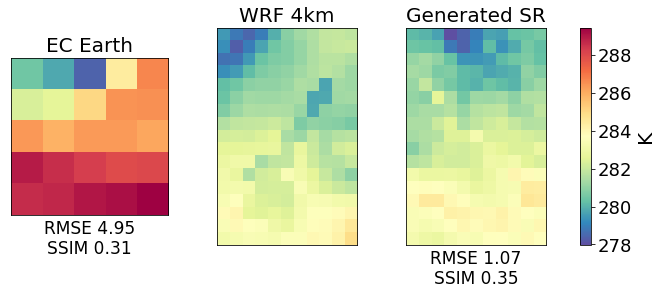

2041-12-01 03:00:00


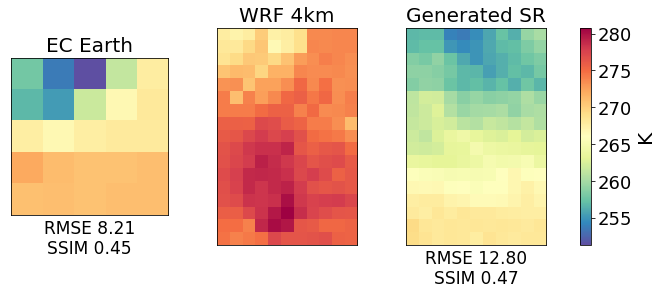

In [66]:
# BEST
t = T_mr_hr_rms_test.index(min(T_mr_hr_rms_test))

print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [T_ECEarth_down[t,:,:,0],T_WRF_4km[t,:,:], T_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(T_rms_ECEarth_downv4km[t],T_ssim_ECEarth_downv4km[t]),'' ,(T_mr_hr_rms_test[t], T_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(T_ECEarth_down[t,:,:,0]),np.min(T_WRF_4km[t,:,:]), np.min(T_mr_hr_test_near[t])]), 
                   vmax=max([np.max(T_ECEarth_down[t,:,:,0]),np.max(T_WRF_4km[t,:,:]), np.max(T_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='K', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/best_SR_T2m_mrhr.pdf',bbox_inches='tight')





# WORST
t = T_mr_hr_rms_test.index(max(T_mr_hr_rms_test))
print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [T_ECEarth_down[t,:,:,0],T_WRF_4km[t,:,:], T_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(T_rms_ECEarth_downv4km[t],T_ssim_ECEarth_downv4km[t]),'' ,(T_mr_hr_rms_test[t], T_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(T_ECEarth_down[t,:,:,0]),np.min(T_WRF_4km[t,:,:]), np.min(T_mr_hr_test_near[t])]), 
                   vmax=max([np.max(T_ECEarth_down[t,:,:,0]),np.max(T_WRF_4km[t,:,:]), np.max(T_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='K', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/worst_SR_T2m_mrhr.pdf',bbox_inches='tight')

2041-11-03 15:00:00


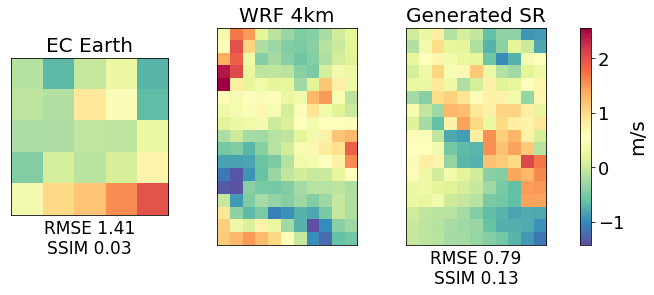

2041-02-06 06:00:00


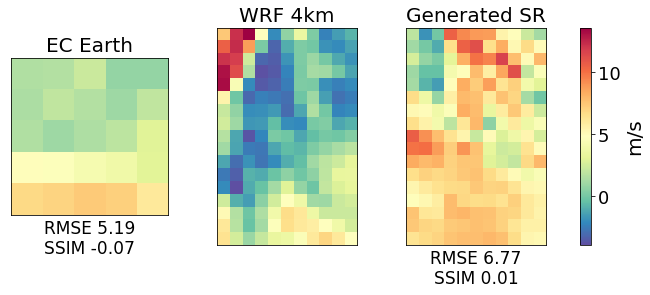

In [75]:
# BEST
t = U_mr_hr_rms_test.index(min(U_mr_hr_rms_test))

print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [U_ECEarth_down[t,:,:,0],U_WRF_4km[t,:,:], U_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(U_rms_ECEarth_downv3km[t],U_ssim_ECEarth_downv3km[t]),'' ,(U_mr_hr_rms_test[t], U_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(U_ECEarth_down[t,:,:,0]),np.min(U_WRF_4km[t,:,:]), np.min(U_mr_hr_test_near[t])]), 
                   vmax=max([np.max(U_ECEarth_down[t,:,:,0]),np.max(U_WRF_4km[t,:,:]), np.max(U_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/best_SR_U10m_mrhr.pdf',bbox_inches='tight')





# WORST
t = U_mr_hr_rms_test.index(max(U_mr_hr_rms_test))
print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [U_ECEarth_down[t,:,:,0],U_WRF_4km[t,:,:], U_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(U_rms_ECEarth_downv3km[t],U_ssim_ECEarth_downv3km[t]),'' ,(U_mr_hr_rms_test[t], U_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(U_ECEarth_down[t,:,:,0]),np.min(U_WRF_4km[t,:,:]), np.min(U_mr_hr_test_near[t])]), 
                   vmax=max([np.max(U_ECEarth_down[t,:,:,0]),np.max(U_WRF_4km[t,:,:]), np.max(U_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/worst_SR_U10m_mrhr.pdf',bbox_inches='tight')

2041-08-03 21:00:00


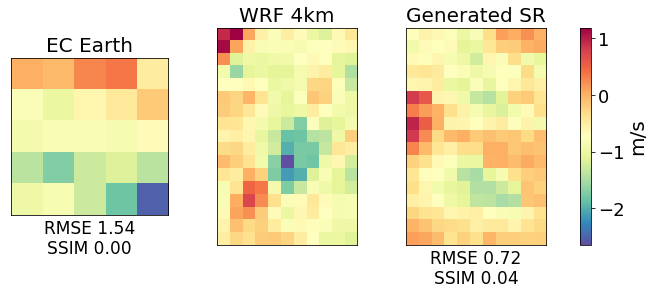

2041-11-26 03:00:00


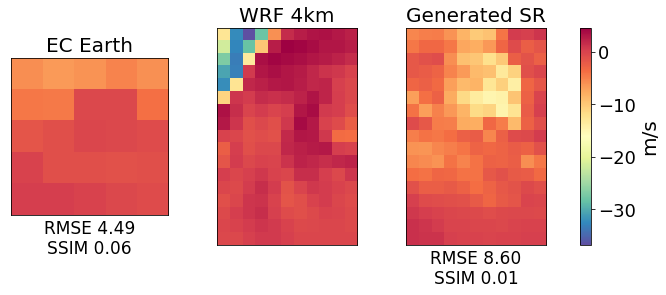

In [76]:
# BEST
t = V_mr_hr_rms_test.index(min(V_mr_hr_rms_test))

print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [V_ECEarth_down[t,:,:,0],V_WRF_4km[t,:,:], V_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(V_rms_ECEarth_downv3km[t],V_ssim_ECEarth_downv3km[t]),'' ,(V_mr_hr_rms_test[t], V_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(V_ECEarth_down[t,:,:,0]),np.min(V_WRF_4km[t,:,:]), np.min(V_mr_hr_test_near[t])]), 
                   vmax=max([np.max(V_ECEarth_down[t,:,:,0]),np.max(V_WRF_4km[t,:,:]), np.max(V_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/best_SR_V10m_mrhr.pdf',bbox_inches='tight')





# WORST
t = V_mr_hr_rms_test.index(max(V_mr_hr_rms_test))
print(index_to_datetime(t,2041))

fig, axs = plt.subplots(1, 3,figsize=(12,4))

for ax, r, title, err in zip(axs.flat,
                         [V_ECEarth_down[t,:,:,0],V_WRF_4km[t,:,:], V_mr_hr_test_near[t]],
                         ['EC Earth','WRF 4km','Generated SR'],
                         [(V_rms_ECEarth_downv3km[t],V_ssim_ECEarth_downv3km[t]),'' ,(V_mr_hr_rms_test[t], V_mr_hr_ssim_test[t])]
                            ):
                    

    im = ax.imshow(np.flipud(r), cmap='Spectral_r',
                   vmin=min([np.min(V_ECEarth_down[t,:,:,0]),np.min(V_WRF_4km[t,:,:]), np.min(V_mr_hr_test_near[t])]), 
                   vmax=max([np.max(V_ECEarth_down[t,:,:,0]),np.max(V_WRF_4km[t,:,:]), np.max(V_mr_hr_test_near[t])]))
    ax.set_title(title, fontsize = fs)
    if title == 'WRF 4km':
        pass
    else:
        ax.set_xlabel('RMSE %.2f\nSSIM %.2f' % err, fontsize = fs-3)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
        
cb = fig.colorbar(im, ax=axs,orientation='vertical')
cb.ax.tick_params(labelsize=fs-2)
cb.set_label(label='m/s', fontsize = fs)

plt.show()

fig.savefig('F:/Master_Thesis/Figures/Future/worst_SR_V10m_mrhr.pdf',bbox_inches='tight')